In [2]:
# Imports
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.metrics import roc_curve
import math

In [3]:
# Load data
data = []
class1 = []
class2 = []
with open('data_3_5.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        data.append([float(row[0]), float(row[1])])
        if row[1] == '1':
            class1.append(float(row[0]))
        else:
            class2.append(float(row[0]))
            
print("Class 1 length: ", len(class1))
print("Class 2 length: ", len(class2))

Class 1 length:  3000
Class 2 length:  1500


### Problem 5A

Mu 1:  1.9993985786113184 Sigma 1:  5.04604258685262
Mu 2:  2.9682945975810497 Sigma 2:  1.9806803152971366
Predicted class 1:  3663
Predicted class 2:  837
TPR:  0.7818608287724785
FPR:  0.0


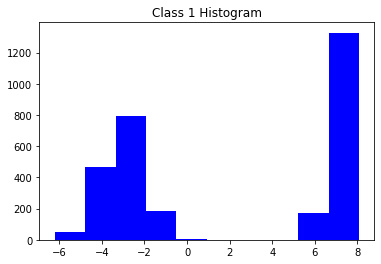

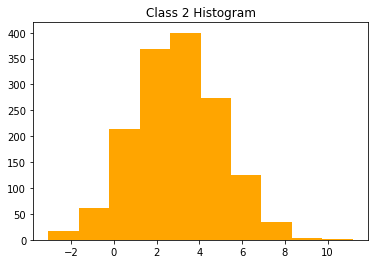

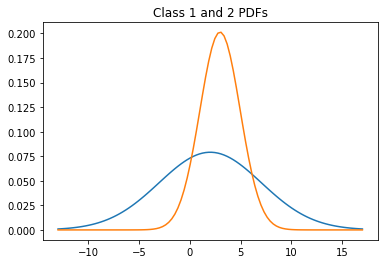

In [16]:
# Construct normal distributions for classes 1 and 2
mu1, sigma1 = norm.fit(class1)
mu2, sigma2 = norm.fit(class2)

print("Mu 1: ", mu1, "Sigma 1: ", sigma1)
print("Mu 2: ", mu2, "Sigma 2: ", sigma2)

# Bayes Classifier: probability that a datapoint belongs in class C given X
# is proportional to the probability of seeing this data point given we are in class C
# times the probability of class C occuring.

# Sooo... sample each X from each distribution, then multiply by the length of that
# distribution. Whichever probability is higher, choose that class.

# Plot histogram of each class of data
ax1, plt1 = plt.subplots()
ax2, plt2 = plt.subplots()
plt1.hist(class1, color='blue')
plt1.set_title("Class 1 Histogram")
plt2.hist(class2, color='orange')
plt2.set_title("Class 2 Histogram")

dist_c1 = norm(mu1, sigma1)
dist_c2 = norm(mu2, sigma2)

# Plot PDFs of each class
x = np.linspace(-13, 17, 100)
ax1, plt3 = plt.subplots()
plt3.plot(x, dist_c1.pdf(x))
plt3.plot(x, dist_c2.pdf(x))
plt3.set_title("Class 1 and 2 PDFs")

len_c1 = len(class1)
len_c2 = len(class2)
len_data = len(data)
predicted = [0, 0] # List to keep track of number of points predicted in each class

tp = 0
fp = 0
tn = 0
fn = 0

target_scores = []

for d in data:
    prob_c1 = dist_c1.pdf(d[0]) * len_c1 / len_data
    prob_c2 = dist_c2.pdf(d[0]) * len_c2 / len_data
    if prob_c1 > prob_c2: # If likelihood of coming from class 1 is higher, predict class 1
        predicted[0] += 1 # Class 1
        target_scores.append(prob_c1)
        # Populate confusion matrix
        if d[1] == 1:
            tp += 1
        else:
            fp += 1
    else:
        predicted[1] += 1 # Class 2
        target_scores.append(prob_c2)
        # Populate confusion matrix
        if d[1] == 0:
            tn += 1
        else:
            fn += 1

# Print statistics about the data
print("Predicted class 1: ", predicted[0])
print("Predicted class 2: ", predicted[1])
print("TPR: ", tp / (tp + fn))
print("FPR: ", tn / (tn + fp))


### Problem 5B
The model does not fit the data all that well because the distributions of each class of data overlap so heavily, as shown in the figure above. The PDFs for Class 1 and Class 2 of the data overlap heavily and have very different shapes. Class 1 is quite spread out from its mean of 1.99, with a variance of 5.04, while Class 2 is concentrated around its mean at 2.97 with a variance of only 1.98. This means that the two PDFs overlap significantly in the range (0, 5), and the model predicts false positives (Class 2) in this range because Class 2's PDF is concentrated in this range. No false negatives occur because there is no point where Class 1 is more likely than Class 2.

### Problem 5C & 5D

Text(0, 0.5, 'TPR')

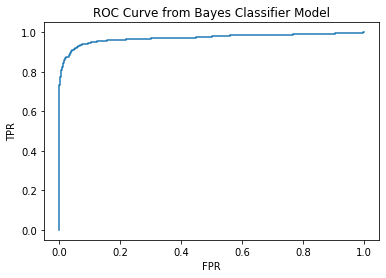

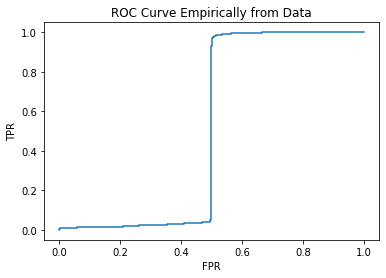

In [15]:
# 5C: Construct and plot ROC curve based on Bayes classifier above
y = np.array([i[1] for i in data])
scores = np.array(target_scores)
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=2)
fig1, ax1 = plt.subplots()
ax1.plot(fpr, tpr)
plt.title(label="ROC Curve from Bayes Classifier Model", loc='center')
plt.xlabel('FPR')
plt.ylabel('TPR')

# 5D: Build ROC empirically from data, NOT estimates
fpr, tpr, thresholds = roc_curve([1] * len(class1) + [2] * len(class2), class1 + class2, pos_label=2)
fig2, ax2 = plt.subplots()
ax2.plot(fpr, tpr)
plt.title(label="ROC Curve Empirically from Data")
plt.xlabel('FPR')
plt.ylabel('TPR')

The ROC curves above show that the Bayes classfier does a pretty good job of classifying the data correctly; the area under the curve is close to 1, meaning that most of the samples are correctly classified.

### Problem 5E
As shown in the histograms above, Class 1 does not follow a normal distribution, and treating it as a normal distribution results in poor classification performance. Better performance could be achieved by modeling Class 1 as some sort of bimodal distribution. For this reason, I suggest that a different model that takes this multimodal behavior into account will probably perform better than the current model.

### Problem 5F

In [21]:
# Function that returns the probability x is in Class 1
def prob_class1(x):
    return 3/4 * norm(-3, 1).pdf(x) + 1/4 * norm(7, 0.316).pdf(x)

# Log likelihood given the new model:
l = 0
oldl = 0
for x in class1:
    l += math.log(prob_class1(x)) # Used Log Likelihood because regular likelihood was too small, became 0.
    oldl += math.log(dist_c1.pdf(x))
    
print("New model: ", l)
print("Old model: ", oldl)

New model:  -4846.214869737819
Old model:  -9112.628469338932


As is apparent from the log likelihoods generated above, the likelihood that the data in Class 1 come from the new model is much higher than the likelihood that they come from the old model; log likelihood returns larger negative values for lower probabilities (log(0.0001) = -4, while log (0.1) = -1). This means that the data more likely come from the new model, which also fits with the histograms generated in part a.

### Problem 5G

In [45]:
# Bic and Bayes Factor

# BIC of original model (2 degrees of freedom):
bic1 = oldl - 2 / 2 * math.log(len(class1))

# BIC of new model (5 degrees of freedom):
bic2 = l - 5 / 2 * math.log(len(class1))

print("BIC old model: ", bic1)
print("BIC new model: ", bic2)
print("Bayes Factor: ", math.exp(bic1) - math.exp(bic2))

BIC old model:  -9120.634836906582
BIC new model:  -4866.230788656944
Bayes Factor:  0.0


BIC of the old and new model are calculated above.


Because the BIC of old and new model are each in log form, we cannot directly do bic1/bic2. We also can't exponentiate them and then calculate the ratio, because the probability values in this case are so small they round to 0 and we would then be dividing by 0. By doing the following, we can subtract the logs of each BIC value to get the log of the overall Bayes Factor:


**log(Bayes Factor) = log(p(D|m1)/p(D|m0)) = log(p(D|m1)) - log(p(D|m0)).**


Finally, we CAN exponentiate these two likelihoods, and we find that the Bayes factor in this case is so near to zero that it rounds to 0, meaning there is decisive evidence for M0, our new model, being the best option.